# Project 2
August Noer Steinset

Adding basic imports and setting up spark and cassandra.

In [1]:
import os
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import json
import scipy.stats as stats
from sklearn.covariance import MinCovDet




os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

## Frost

Getting the api username and setting the date and location based on the data from project1

In [3]:
# Frost API credentials
with open("secrets.txt", "r") as f:
    client_id = f.readlines()[4].strip()

start_date = '2020-01-01'  # Replace with your start date
end_date = '2020-12-31'  # Replace with your end date
latitude = 58.91455  # Replace with the latitude for your location
longitude = 6.028583  # Replace with the longitude for your location

Find the 10 nearest sources.

In [6]:
# Base URL for the Frost API
BASE_URL = "https://frost.met.no"

# Define endpoint and parameters to find the nearest data source
endpoint_sources = "/sources/v0.jsonld"
params_sources = {
    "geometry": "nearest(POINT({lon} {lat}))".format(lon=longitude, lat=latitude),
    "nearestmaxcount": "10"
}

# Issue an HTTP GET request to find the nearest source
response_sources = requests.get(BASE_URL + endpoint_sources, params_sources, auth=(client_id, ''))

# Check if the request worked, print out any errors
if response_sources.status_code == 200:
    nearest_sources = response_sources.json()['data']
    print('Data retrieved from frost.met.no!')
else:
    error_data = response_sources.json()
    print(f"Error! Returned status code {response_sources.status_code}")
    print(f"Message: {error_data['error']['message']}")
    print(f"Reason: {error_data['error']['reason']}")

Data retrieved from frost.met.no!


Look at those weather stations and find the one with the most data.

In [7]:
def get_data_length_for_source(source_id, required_elements, start_date, end_date):
    # Define endpoint and parameters to get observations
    endpoint_obs = "/observations/v0.jsonld"
    params_obs = {
        'sources': source_id,
        'elements': ','.join(required_elements),
        'referencetime': f"{start_date}/{end_date}",
    }

    # Issue an HTTP GET request to get observations
    response_obs = requests.get(BASE_URL + endpoint_obs, params_obs, auth=(client_id, ''))
    
    if response_obs.status_code != 200:
        return 0  # If there's an error, return a length of 0
    
    # Return the length of the JSON data
    return len(response_obs.text)

# Define the required elements
required_elements = [
    'mean(air_temperature P1D)',
    'sum(precipitation_amount P1D)',
    'mean(wind_speed P1D)',
    'mean(relative_humidity P1D)'
]

# Get the data length for each source and identify the source with the maximum length
data_lengths = {source['id']: get_data_length_for_source(source['id'], required_elements, start_date, end_date) for source in nearest_sources}
selected_source = max(data_lengths, key=data_lengths.get)

print(f"Selected source ID with most comprehensive data: {selected_source}")

Selected source ID with most comprehensive data: SN45530


Get the weather data from that source.

In [8]:
# with the selected source, get the data
# Define endpoint and parameters to get observations
endpoint_obs = "/observations/v0.jsonld"
params_obs = {
    'sources': selected_source,
    'elements': ','.join(required_elements),
    'referencetime': f"{start_date}/{end_date}",
}

# Issue an HTTP GET request to get observations
response_obs = requests.get(BASE_URL + endpoint_obs, params_obs, auth=(client_id, ''))
observation_data = response_obs.json()['data']

### Making the tables

Convert the json into a pandas dataframe

In [9]:
# Convert the observation data into a pandas DataFrame
dfs = []  # List to store individual DataFrames
for entry in observation_data:
    row = pd.DataFrame(entry['observations'])
    row['referenceTime'] = entry['referenceTime']
    row['sourceId'] = entry['sourceId']
    dfs.append(row)

# Concatenate all the individual DataFrames into one
df = pd.concat(dfs, ignore_index=True)
print(f"Shape of DataFrame: {df.shape}")
df.head()  # Display the first few rows of the DataFrame

Shape of DataFrame: (2190, 12)


,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,mean(air_temperature P1D),4.0,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2020-01-01T00:00:00.000Z,SN45530:0
1,mean(air_temperature P1D),3.1,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,2.0,2020-01-01T00:00:00.000Z,SN45530:0
2,sum(precipitation_amount P1D),4.4,mm,NaN,PT18H,P1D,0,C,2,2.0,2020-01-01T00:00:00.000Z,SN45530:0
3,sum(precipitation_amount P1D),3.0,mm,NaN,PT6H,P1D,0,C,2,0.0,2020-01-01T00:00:00.000Z,SN45530:0
4,mean(wind_speed P1D),3.4,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2020-01-01T00:00:00.000Z,SN45530:0


Make it neater

In [10]:
# These additional columns will be kept
columns = ['referenceTime','elementId','value', 'timeOffset']
df2 = df[columns].copy()
df2['referenceTime'] = pd.to_datetime(df2['referenceTime'])
df2['timeOffset'] = pd.to_timedelta(df2['timeOffset'])
df2['observationTime'] = df2['referenceTime'] + df2['timeOffset']
df2.drop(columns=['referenceTime', 'timeOffset'], inplace=True)
df2 = df2.pivot(index='observationTime', columns='elementId', values='value')
df2.rename(columns={
    'mean(air_temperature P1D)': 'air_temperature(°C)',
    'sum(precipitation_amount P1D)': 'precipitation_amount(mm)',
    'mean(wind_speed P1D)': 'wind_speed(m/s)',
    'mean(relative_humidity P1D)': 'relative_humidity(%)'
}, inplace=True)
df2.reset_index(inplace=True)
df2.rename(columns={'observationTime': 'datetime'}, inplace=True)
# drop elementid as index   
df2.head()

# i don't know why, but this doesn't work

elementId,datetime,air_temperature(°C),relative_humidity(%),wind_speed(m/s),precipitation_amount(mm)
0,2020-01-01 00:00:00+00:00,4.0,87.0,3.4,NaN
1,2020-01-01 06:00:00+00:00,3.1,NaN,NaN,3.0
2,2020-01-01 18:00:00+00:00,NaN,NaN,NaN,4.4
3,2020-01-02 00:00:00+00:00,5.2,81.0,5.9,NaN
4,2020-01-02 06:00:00+00:00,4.3,NaN,NaN,1.7


Make it work? Probably something to do with the pivot.

In [11]:
# create a new table df3
df3 = pd.DataFrame()
df3['datetime'] = df2['datetime']
df3['air_temperature'] = df2['air_temperature(°C)']
df3['precipitation_amount'] = df2['precipitation_amount(mm)']
df3['wind_speed'] = df2['wind_speed(m/s)']
df3['relative_humidity'] = df2['relative_humidity(%)']
df3.head()

# I dont understand why this works, but it does


,datetime,air_temperature,precipitation_amount,wind_speed,relative_humidity
0,2020-01-01 00:00:00+00:00,4.0,NaN,3.4,87.0
1,2020-01-01 06:00:00+00:00,3.1,3.0,NaN,NaN
2,2020-01-01 18:00:00+00:00,NaN,4.4,NaN,NaN
3,2020-01-02 00:00:00+00:00,5.2,NaN,5.9,81.0
4,2020-01-02 06:00:00+00:00,4.3,1.7,NaN,NaN


Get the dataframe into cassandra using spark

In [12]:

# set up cassandra table
session.execute("CREATE KEYSPACE IF NOT EXISTS project_2 WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1}")
session.set_keyspace('project_2')
session.execute("DROP TABLE IF EXISTS project_2.weather")
session.execute("CREATE TABLE IF NOT EXISTS project_2.weather (datetime timestamp PRIMARY KEY, air_temperature float, precipitation_amount float, wind_speed float, relative_humidity float)")

spark_df = spark.createDataFrame(df3)
spark_df.write\
    .format("org.apache.spark.sql.cassandra")\
    .mode('append')\
    .options(table="weather", keyspace="project_2")\
    .save()



c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


Check if it upload/download properly

In [13]:
# load data from cassandra
df3 = spark.read\
    .format("org.apache.spark.sql.cassandra")\
    .options(table="weather", keyspace="project_2")\
    .load()

# convert to pandas dataframe
df3 = df3.toPandas()
df3.head()

c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):


,datetime,air_temperature,precipitation_amount,relative_humidity,wind_speed
0,2020-05-26 08:00:00,9.4,0.0,NaN,NaN
1,2020-11-15 01:00:00,10.6,NaN,77.0,3.2
2,2020-02-24 01:00:00,0.9,NaN,72.0,1.8
3,2020-04-11 20:00:00,NaN,14.0,NaN,NaN
4,2020-01-18 01:00:00,2.6,NaN,81.0,2.4


Reorder the data into weeks, the values represents the mean value for that week. A further look into if this makes sense given the data would be a good idea.

In [14]:
# order by datetime
df4 = df3.sort_values(by=['datetime'])

# group by weeks
df4['week'] = df4['datetime'].dt.isocalendar().week
df4 = df4.groupby(['week']).mean()
df4.drop(columns=['datetime'], inplace=True)
df4.head()

,air_temperature,precipitation_amount,relative_humidity,wind_speed
week,,,,
1,2.860000,11.390000,82.599998,4.000000
2,3.542857,20.278570,82.571426,3.514286
3,3.792857,12.821428,77.571426,3.385714
4,3.907143,14.600000,80.857140,2.871429
5,2.778572,9.707144,76.285713,2.357143


## Load from project1

Load the lice data and order it by week

In [15]:
lice_data = spark.read.format("org.apache.spark.sql.cassandra").options(table="table3", keyspace="project1").load()

# sort by week
lice_data = lice_data.sort('week')
lice_pd = lice_data.toPandas()
lice_pd.head()

,week,avgadultfemalelice,avgmobilelice,avgstationarylice,hasreportedlice,year
0,1,0.01,0.12,0.08,True,2020
1,2,0.00,0.12,0.15,True,2020
2,3,0.01,0.65,0.14,True,2020
3,4,0.04,0.55,0.08,True,2020
4,5,0.02,0.62,0.04,True,2020


### smoothing

Smooth the data with a simple rolling mean.

In [18]:
window_size = 3


lice_pd['smooth_avgAdultFemaleLice'] = lice_pd['avgadultfemalelice'].rolling(window=window_size).mean()
lice_pd['smooth_avgMobileLice'] = lice_pd['avgmobilelice'].rolling(window=window_size).mean()
lice_pd['smooth_avgStationaryLice'] = lice_pd['avgstationarylice'].rolling(window=window_size).mean()

lice_pd.set_index('week', inplace=True)
lice_pd.head()

# fill na with 0
lice_pd.fillna(0, inplace=True)
lice_pd.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,hasreportedlice,year,smooth_avgAdultFemaleLice,smooth_avgMobileLice,smooth_avgStationaryLice
week,,,,,,,,
1,0.01,0.12,0.08,True,2020,0.000000,0.000000,0.000000
2,0.00,0.12,0.15,True,2020,0.000000,0.000000,0.000000
3,0.01,0.65,0.14,True,2020,0.006667,0.296667,0.123333
4,0.04,0.55,0.08,True,2020,0.016667,0.440000,0.123333
5,0.02,0.62,0.04,True,2020,0.023333,0.606667,0.086667


### Robust statistics

Calculate a mean and covariance that takes outliers into consideration.

In [19]:
pdata = lice_pd[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']]

robust_mean = stats.trim_mean(pdata.values, 0.05)

mcd = MinCovDet(random_state=0).fit(pdata.values)
robust_covariance = mcd.covariance_

# print the values
print("Robust Mean:")
print(robust_mean)
print("Robust Covariance:")
print(robust_covariance)


Robust Mean:
[0.15249999 0.59083337 0.07083333]
Robust Covariance:
[[ 0.00582927  0.00702927 -0.00116341]
 [ 0.00702927  0.09966936  0.00301505]
 [-0.00116341  0.00301505  0.0028564 ]]


Plot the smoothed lice values

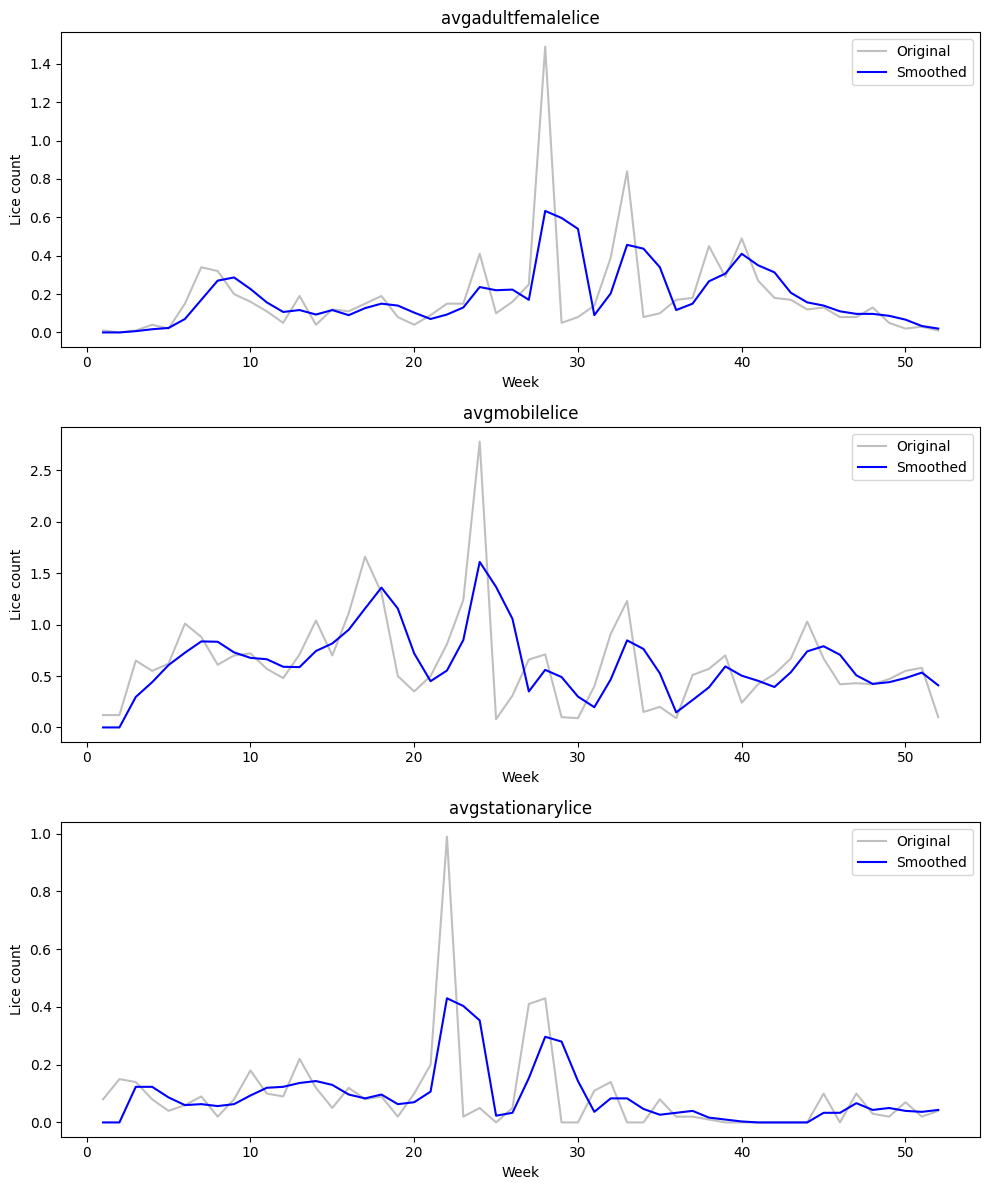

In [20]:

fig, axes = plt.subplots(nrows=3, figsize=(10, 12))

columns = ['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']
smooth_columns = ['smooth_avgAdultFemaleLice', 'smooth_avgMobileLice', 'smooth_avgStationaryLice']

for i, ax in enumerate(axes):
    lice_pd[columns[i]].plot(ax=ax, color='grey', alpha=0.5)
    lice_pd[smooth_columns[i]].plot(ax=ax, color='blue')
    ax.set_title(columns[i])
    ax.set_xlabel('Week')
    ax.set_ylabel('Lice count')
    ax.legend(['Original', 'Smoothed'])

plt.tight_layout()
plt.show()

Implement the hotellings T2 dist and plot the outliers.

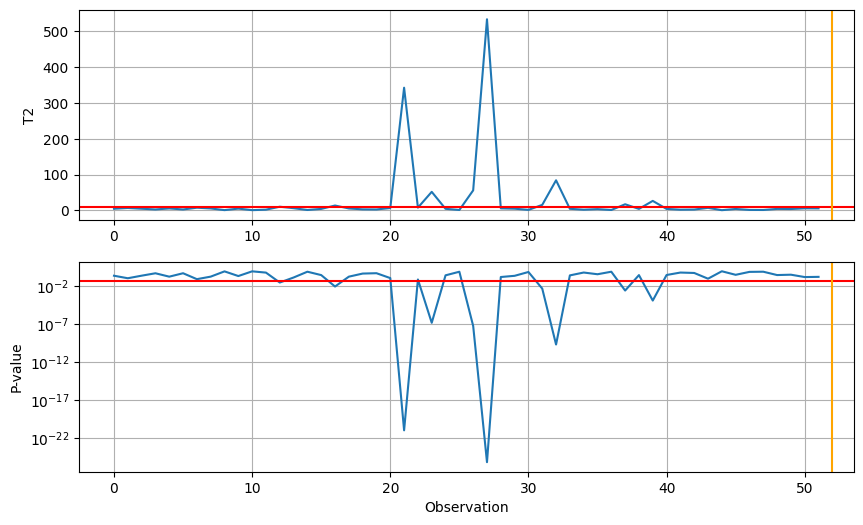

In [21]:
def Hotellings_T2(X, mean, cov, n, alpha = 0.01):
    T2 = np.sum(((X-mean) @ np.linalg.inv(cov)) * (X-mean), axis=-1)
    p = len(mean)
    F = (n-p)/(p*(n-1))*T2
    P = stats.f.sf(F, p, n-p)
    # Critical value
    c = stats.f.isf(alpha, p, n-p)*p*(n-1)/(n-p)
    return (T2, F, P, c)

alpha = 0.05
# Apply Hotellings_T2 and plot
T2, F, P, c = Hotellings_T2(pdata.values, robust_mean, robust_covariance, len(pdata), alpha)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(T2)
plt.grid()
plt.axhline(c, color="red")
plt.axvline(len(pdata), color="orange")
plt.ylabel("T2")
plt.subplot(212)
# Plot P on a logarithmic scale
plt.plot(P)
plt.yscale("log")
plt.grid()
plt.axhline(alpha, color="red")
plt.axvline(52, color="orange")
plt.ylabel("P-value")
plt.xlabel("Observation")
plt.show()

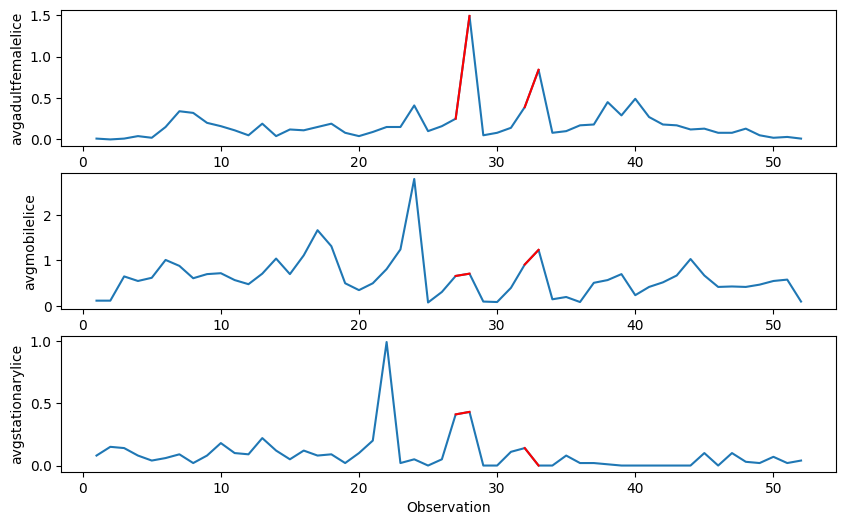

In [22]:
# Plot the three variables as separate subplots above each other, marking the outlying regions in red
x = np.arange(52)+1.0
x[P>alpha] = np.nan

plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(pdata['avgadultfemalelice'], '-')
plt.plot(x, pdata['avgadultfemalelice'], '-', color='red')
plt.ylabel('avgadultfemalelice')
plt.subplot(312)
plt.plot(pdata['avgmobilelice'], '-')
plt.plot(x, pdata['avgmobilelice'], '-', color='red')
plt.ylabel('avgmobilelice')
plt.subplot(313)
plt.plot(pdata['avgstationarylice'], '-')
plt.plot(x, pdata['avgstationarylice'], '-', color='red')
plt.ylabel('avgstationarylice')
plt.xlabel('Observation')
plt.show()

The low resolution make it seem like only a few areas are marked as outliers. for a region to be colored red we need to have two concecutive points, something that doesn't happen too often when theres only 52 units in the x axis.

## Merge the tables and upload

In [23]:
# merge licedata and weatherdata
# merge the two dataframes
df5 = pd.merge(lice_pd, df4 , left_index=True, right_index=True)
df5.drop(columns=['year', 'hasreportedlice'], inplace=True)
df5.reset_index(inplace=True, drop=False)
df5.columns = map(str.lower, df5.columns)
df5.head()

,week,avgadultfemalelice,avgmobilelice,avgstationarylice,smooth_avgadultfemalelice,smooth_avgmobilelice,smooth_avgstationarylice,air_temperature,precipitation_amount,relative_humidity,wind_speed
0,1,0.01,0.12,0.08,0.000000,0.000000,0.000000,2.860000,11.390000,82.599998,4.000000
1,2,0.00,0.12,0.15,0.000000,0.000000,0.000000,3.542857,20.278570,82.571426,3.514286
2,3,0.01,0.65,0.14,0.006667,0.296667,0.123333,3.792857,12.821428,77.571426,3.385714
3,4,0.04,0.55,0.08,0.016667,0.440000,0.123333,3.907143,14.600000,80.857140,2.871429
4,5,0.02,0.62,0.04,0.023333,0.606667,0.086667,2.778572,9.707144,76.285713,2.357143


In [24]:
# set up cassandra table
#delete the table
session.execute("DROP TABLE IF EXISTS project_2.lice_weather")
session.execute("CREATE TABLE IF NOT EXISTS project_2.lice_weather (week int PRIMARY KEY, avgadultfemalelice float, avgmobilelice float, avgstationarylice float, smooth_avgadultfemalelice float, smooth_avgmobilelice float, smooth_avgstationarylice float, air_temperature float, precipitation_amount float, wind_speed float, relative_humidity float)")

spark_df = spark.createDataFrame(df5)

c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


Upload and download and see if it works

In [25]:
# write to cassandra
spark_df.write\
    .format("org.apache.spark.sql.cassandra")\
    .mode('append')\
    .options(table="lice_weather", keyspace="project_2")\
    .save()

# load data from cassandra
df6 = spark.read\
    .format("org.apache.spark.sql.cassandra")\
    .options(table="lice_weather", keyspace="project_2")\
    .load()

# convert to pandas dataframe
df6 = df6.toPandas()
df6.head()

,week,air_temperature,avgadultfemalelice,avgmobilelice,avgstationarylice,precipitation_amount,relative_humidity,smooth_avgadultfemalelice,smooth_avgmobilelice,smooth_avgstationarylice,wind_speed
0,33,17.714285,0.84,1.23,0.00,0.000000,69.285713,0.456667,0.846667,0.083333,1.628571
1,5,2.778572,0.02,0.62,0.04,9.707144,76.285713,0.023333,0.606667,0.086667,2.357143
2,28,9.885714,1.49,0.71,0.43,14.307143,76.428574,0.633333,0.560000,0.296667,2.714286
3,14,2.264286,0.04,1.04,0.12,8.407144,77.428574,0.093333,0.743333,0.143333,3.000000
4,36,11.457143,0.17,0.09,0.02,13.992857,82.142860,0.116667,0.146667,0.033333,2.314286
